# Noun Semantics in the Hebrew Bible

*This notebook will contain the descriptions and analysis for the presentation on noun semantics in the Hebrew Bible.*

In [5]:
# ETCBC's BHSA data
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa

# stats & data-containers
import collections
import pandas as pd
import numpy as np
import scipy.stats as stats

# data visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

# prep the data
name = 'noun_semantics'
hebrew_data = ['~/github/etcbc/{}/tf/c'.format(direc) for direc in ('bhsa','lingo/heads', 'phono')] # data dirs
load_features = '''
heads typ phono lex_utf8 freq_lex
''' 

# TF load statements
TF = Fabric(locations=hebrew_data, silent=True)
api = TF.load(load_features)
B = Bhsa(api=api, hoist=globals(), silent=True, name=name) # Bhsa functions for search and visualizing text

  0.00s loading features ...
   |     0.18s B lex_utf8             from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.21s B phono                from /Users/cody/github/etcbc/phono/tf/c
   |     2.94s B heads                from /Users/cody/github/etcbc/lingo/heads/tf/c
   |     0.18s B typ                  from /Users/cody/github/etcbc/bhsa/tf/c
   |     0.08s B freq_lex             from /Users/cody/github/etcbc/bhsa/tf/c
  8.85s All features loaded/computed - for details use loadLog()


In [ ]:
def reverse_hb(heb_text):
    return ''.join(reversed(heb_text))

## Define a Target Noun Set

*Insert discussion about the semantic relationship between iconicity and frequency with regards to the most frequent noun lexemes in the HB.*

*Also some discussion about Zipfian curves.

In [58]:
search_set = 'lex sp=subs'

all_nouns = B.search(search_set)

  0.01s 4076 results


### Plot the Nouns in Order of Frequency

[]

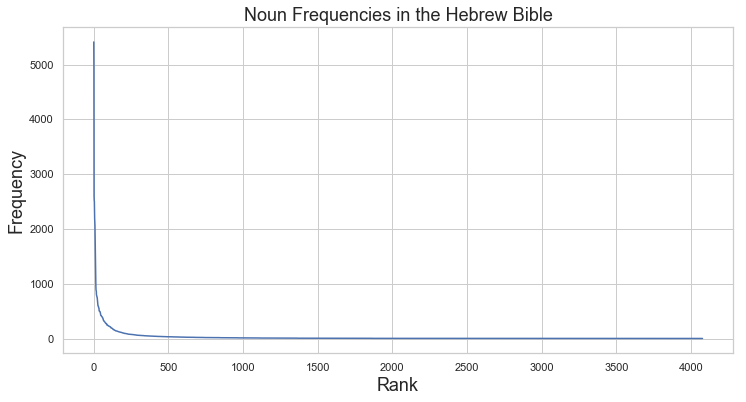

In [63]:
ordered = sorted(((F.freq_lex.v(res[0]), F.lex_utf8.v(L.d(res[0], 'word')[0])) for res in all_nouns), reverse=True)
y_freqs = [lex_data[0] for lex_data in ordered]
x_count = [i+1 for i in range(0, len(y_freqs))]
terms = [lex_data[1] for lex_data in ordered]

title = 'Noun Frequencies in the Hebrew Bible'
xlabel = 'Rank'
ylabel = 'Frequency'

plt.figure(figsize=(12, 6))
plt.plot(x_count, y_freqs)
plt.title(title, size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

[]

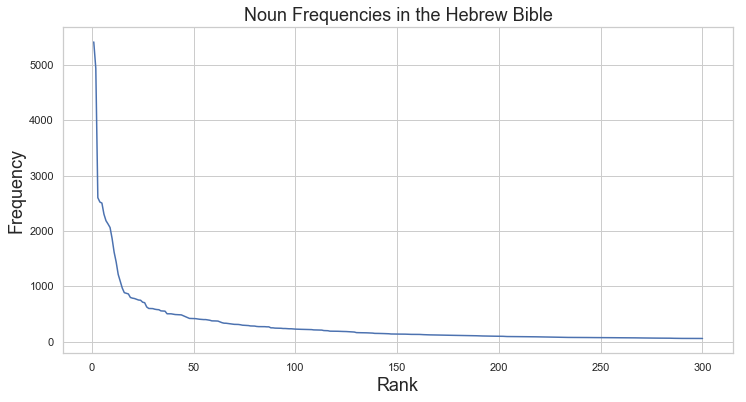

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(x_count[:300], y_freqs[:300])
plt.title(title, size=18)
plt.xlabel(xlabel, size=18)
plt.ylabel(ylabel, size=18)
plt.plot()

This curve is typical of Zipf's law:

> Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table ([wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law))

The curve "elbows" at around rank 25.